In [12]:
!pip install netCDF4 
!pip install matplotlib 
!pip install numpy 
!pip install folium
!pip install geojsoncontour

In [13]:
import folium 
from wrf import getvar, interplevel, to_np, latlon_coords
from folium import plugins
from netCDF4 import Dataset as NetCDFFile
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import geojsoncontour
import json

In [14]:
nc = NetCDFFile('/work/syseng/baq-air-quality-estimation/wrfout_d01_2020-01-01_00:00:00')

In [15]:
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    TITLE:  OUTPUT FROM WRF V4.2 MODEL
    START_DATE: 2020-01-01_00:00:00
    SIMULATION_START_DATE: 2020-01-01_00:00:00
    WEST-EAST_GRID_DIMENSION: 100
    SOUTH-NORTH_GRID_DIMENSION: 75
    BOTTOM-TOP_GRID_DIMENSION: 35
    DX: 1000.0
    DY: 1000.0
    AERCU_OPT: 0
    AERCU_FCT: 1.0
    IDEAL_CASE: 0
    DIFF_6TH_SLOPEOPT: 0
    AUTO_LEVELS_OPT: 2
    DIFF_6TH_THRESH: 0.1
    DZBOT: 50.0
    DZSTRETCH_S: 1.3
    DZSTRETCH_U: 1.1
    SKEBS_ON: 0
    SPEC_BDY_FINAL_MU: 1
    USE_Q_DIABATIC: 0
    GRIDTYPE: C
    DIFF_OPT: 0
    KM_OPT: 1
    DAMP_OPT: 0
    DAMPCOEF: 0.01
    KHDIF: 0.0
    KVDIF: 0.0
    MP_PHYSICS: 3
    RA_LW_PHYSICS: 1
    RA_SW_PHYSICS: 1
    SF_SFCLAY_PHYSICS: 1
    SF_SURFACE_PHYSICS: 1
    BL_PBL_PHYSICS: 1
    CU_PHYSICS: 1
    SF_LAKE_PHYSICS: 0
    SURFACE_INPUT_SOURCE: 1
    SST_UPDATE: 0
    GRID_FDDA: 0
    GFDDA_INTERVAL_M: 0
    GFDDA_END_H: 0
    GRID_SFDDA: 0
  

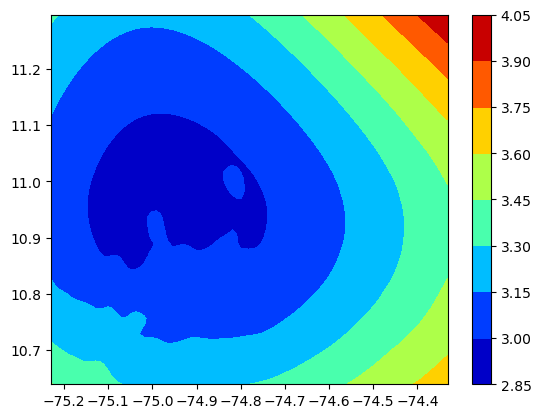

In [16]:
def get_wind_data(data: NetCDFFile, t: int, z: int):
    z *= 1000
    height = getvar(data, "height")
    u_all = getvar(data, 'ua')
    v_all = getvar(data, 'va')
    w_all = getvar(data, 'wa')
    T_all=getvar(nc,'tc')
    T = interplevel(T_all, height, z)
    u = interplevel(u_all, height, z)
    v = interplevel(v_all, height, z)
    w = interplevel(w_all, height, z)
    return T, u, v, np.sqrt(u**2+v**2+w**2) 

T, U, V, mag= get_wind_data(nc, t=1, z=6)
lats, lons = latlon_coords(mag)

figure = plt.figure()
ax = figure.add_subplot(111)
contour = ax.contourf(lons, lats, mag, cmap=plt.cm.jet)
cbar = figure.colorbar(contour)

figure
####################################################################
# SI SE VE RARAS LAS LINEAS AL EJECUTAR FOLIUM CAMBIAR LAST Y LONS #
####################################################################

In [17]:
gj_str = geojsoncontour.contourf_to_geojson(
    contourf=contour,
    ndigits=3,
      unit='m'
)
gj=json.loads(gj_str)

In [18]:
# # convert to (n, 2) nd-array format for heatmap
# stationArr = df_mag[['XLAT', 'XLONG']]
# stationArr
# mapa = folium.Map(location=[lats.mean(), lons.mean()], tiles="Cartodb Positron",zoom_start=11)     
# mapa



mapa = folium.Map(location=[lats.mean(), lons.mean()], tiles="Cartodb Positron",
                  zoom_start=10)

folium.GeoJson(gj, style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'opacity':   0.6,
    },name="geojson").add_to(mapa)

mapa